# Survival Probability Data Generations

## Packages

In [51]:
#Import the necessary packages
import numpy as np
import math
import scipy
from scipy.linalg import expm
import matplotlib as mpl #Package for plotting
import matplotlib.pyplot as plt #Package for plotting
import matplotlib.font_manager as fm #Package for fonts of plots
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset) #Formatting of plots
import time #To calculate the computation time of a piece of code
#from pylab import cm #Colours of plots
#from scipy import linalg
#from scipy.linalg import expm, sqrtm
from qutip import * #Quantum toolbox in python - a really nice package for anything 'quantum'-related
import networkx as nx
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from scipy import linalg as ls 
from scipy.signal import find_peaks
import glob
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as tck
import matplotlib.patches as patches
import multiprocessing as mp
import os
import pickle 
import scipy.linalg as la
from multiprocessing import Pool

#Figure formatting settings - my personal preferences - you can change these if you like.
#This should however format figures in a way that is appropriate for formal publications.
mpl.rcParams['font.family'] = 'serif' #'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

#Set options for later computations - we will probably not need this!
#options = Options(nsteps=int(1e6), normalize_output=False, atol=1e-9, rtol=1e-7)

#Function to change the plot axes, set the plot range, and tick mark intervals. 
#Function takes in an axis object, and the plot range in the form of a list [[x_min, x_max],[y_min, y_max]], and 
#tick marks [x ticks major interval, x ticks minor interval, y ticks major interval, y ticks minor interval]
def plot_settings(ax=None, plot_range=[], ticks=[]):
    #If no axis object is given, take the last set of active plot axes
    if ax is None:
        ax = plt.gca()
    #Plot formatting
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False) #Hide the top and right spines of the axis
    if plot_range:
        ax.set_xlim(plot_range[0][0], plot_range[0][1]); ax.set_ylim(plot_range[1][0], plot_range[1][1]) #Set the plot range of the axes
    # Edit the major and minor ticks of the x and y axes - linewidth, size, direction 
    ax.xaxis.set_tick_params(which='major', size=6, width=1, direction='in')
    ax.xaxis.set_tick_params(which='minor', size=3, width=0.8, direction='in')
    ax.yaxis.set_tick_params(which='major', size=6, width=1, direction='in')
    ax.yaxis.set_tick_params(which='minor', size=3, width=0.8, direction='in')
    #Set intervals between ticks
    if ticks:
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(ticks[0]))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(ticks[1]))
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(ticks[2]))
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ticks[3]))
    #ax.plot(x, y, **plt_kwargs) ## example plot here
    return(ax)

def plot_settings_Framed(ax=None, plot_range=[], ticks=[]):
    #If no axis object is given, take the last set of active plot axes
    if ax is None:
        ax = plt.gca()
    #Plot formatting
    #ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False) #Hide the top and right spines of the axis
    if plot_range:
        ax.set_xlim(plot_range[0][0], plot_range[0][1]); ax.set_ylim(plot_range[1][0], plot_range[1][1]) #Set the plot range of the axes
    # Edit the major and minor ticks of the x and y axes - linewidth, size, direction 
    ax.xaxis.set_tick_params(which='major', size=6, width=1, direction='in')
    ax.xaxis.set_tick_params(which='minor', size=3, width=0.8, direction='in')
    ax.yaxis.set_tick_params(which='major', size=6, width=1, direction='in')
    ax.yaxis.set_tick_params(which='minor', size=3, width=0.8, direction='in')
    #Set intervals between ticks
    if ticks:
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(ticks[0]))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(ticks[1]))
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(ticks[2]))
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ticks[3]))
    #ax.plot(x, y, **plt_kwargs) ## example plot here
    return(ax)

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

## Data generation

### Definitions

In [ ]:
def H_CG(N, gamma, w, kappa):
    """Generate the Hamiltonian for the Complete Graph."""
    ket_s = np.ones((N, 1)) / np.sqrt(N)
    H = -gamma * N * ket_s @ ket_s.T.conj()
    H = H.astype(complex)
    H[w, w] -= (1 + 1j * kappa)  # Target site
    return H.astype(complex)

def surv_prob(Tcutoff, dt, r, N, gamma, w, kappa):
    """Compute the survival probability as a function of time."""
    m = int(Tcutoff / dt)  # Number of time steps
    H = H_CG(N, gamma, w, kappa)
    psi_0 = np.ones((N, 1)) / np.sqrt(N)  # Initial state (uniform superposition)
    psi_r = psi_0.copy()  # Reset state
    
    s_prob = np.zeros(m)
    s_prob[0] = 1.0  # Initial survival probability
    
    ut = la.expm(-1j * H * dt)  # Time evolution operator

    for j in range(1, m): 
        psit = ut @ psi_0
        s_prob[j] = np.vdot(psit, psit).real  # Survival probability

        if r == 0: #No reset condition
            psi_0 = psit
        else:
            if j%r != 0:  #normal condition    
                psi_0 = psit  
            else: # reset conditions
                psi_0 = np.sqrt(s_prob[j])*psi_r

    return s_prob

def find_transition_point(arr, Tcutoff, dt):
    """Find the first time index where the survival probability drops below 0.5."""
    idx = np.where(arr <= 0.5)[0]
    return idx[0] * dt if len(idx) > 0 else 0  # Return first occurrence or 0

def find_transition_point2(arr, Tcutoff, dt):
    left, right = 0, len(arr) - 1
    
    while left < right:
        mid = (left + right) // 2
        if arr[mid] > 0.5:
            left = mid + 1  # Search in the right half
        else:
            right = mid  # Search in the left half
            
    return left * dt if arr[left] <= 0.5 else 0  # Return index or 0 if no transition

def compute_survival_probabilities(gg_gamma):
    gg, gamma = gg_gamma
    local_T_decay0p5 = np.zeros((len(kappa_vals), len(r_vals)))
    local_s_prob_arr = np.zeros((len(kappa_vals), len(r_vals), int(Tcutoff / dt)))
    
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
            local_s_prob_arr[kk, rr] = s_prob
            local_T_decay0p5[kk, rr] = find_transition_point(s_prob, Tcutoff, dt)
    
    return gg, local_T_decay0p5, local_s_prob_arr

### Single-core processing

In [ ]:
# Parameters
Tcutoff = 400
dt = 0.01
r_vals = np.linspace(1, (Tcutoff+1)/dt, 200, dtype=int)
kappa_vals = np.linspace(0, 0.4, 200)
N = 100  # System size
w = 10  # Target site
gamma_vals = np.linspace(0.8/N, 1.2/N, 200)

# Storage Arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
            s_prob_arr[gg, kk, rr] = s_prob
            #print(find_transition_point2(s_prob, Tcutoff, dt),gamma,kappa,r)
            T_decay0p5[gg, kk, rr] = find_transition_point(s_prob, Tcutoff, dt)
            

filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

### Parallel processing

In [ ]:
# Parameters
Tcutoff = 400
dt = 0.01
r_vals = np.linspace(1, (Tcutoff+1)/dt, 200, dtype=int)
kappa_vals = np.linspace(0, 0.4, 200)
N = 100  # System size
w = 10  # Target site
gamma_vals = np.linspace(0.8/N, 1.2/N, 200)

# Initialize arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Use multiprocessing
with Pool() as pool:
    results = list(tqdm(pool.imap(compute_survival_probabilities, enumerate(gamma_vals)), total=len(gamma_vals)))
    #results = list(tqdm(pool.imap_unordered(compute_survival_probabilities, gamma_vals), total=len(gamma_vals)))

# Store results back into the arrays
for gg, local_T_decay0p5, local_s_prob_arr in results:
    T_decay0p5[gg] = local_T_decay0p5
    s_prob_arr[gg] = local_s_prob_arr


8000000

In [ ]:
def compute_survival_probabilities(gg, gamma, kappa_vals, r_vals, Tcutoff, dt, N, w):
    local_T_decay0p5 = np.zeros((len(kappa_vals), len(r_vals)))
    local_s_prob_arr = np.zeros((len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
            local_s_prob_arr[kk, rr] = s_prob
            local_T_decay0p5[kk, rr] = find_transition_point(s_prob, Tcutoff, dt)

    return gg, local_T_decay0p5, local_s_prob_arr

# Initialize arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Prepare input arguments for starmap
args = [(gg, gamma, kappa_vals, r_vals, Tcutoff, dt, N, w) for gg, gamma in enumerate(gamma_vals)]

# Use multiprocessing
with Pool() as pool:
    results = list(tqdm(pool.starmap(compute_survival_probabilities, args, chunksize=1), total=len(gamma_vals)))

# Store results back into the arrays
for gg, local_T_decay0p5, local_s_prob_arr in results:
    T_decay0p5[gg] = local_T_decay0p5
    s_prob_arr[gg] = local_s_prob_arr


In [ ]:
def compute_survival_probabilities(args):
    gg, gamma, kappa_vals, r_vals, Tcutoff, dt, N, w = args
    local_T_decay0p5 = np.zeros((len(kappa_vals), len(r_vals)))
    local_s_prob_arr = np.zeros((len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
            local_s_prob_arr[kk, rr] = s_prob
            local_T_decay0p5[kk, rr] = find_transition_point(s_prob, Tcutoff, dt)

    return gg, local_T_decay0p5, local_s_prob_arr

# Initialize arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Prepare input arguments for map
args = [(gg, gamma, kappa_vals, r_vals, Tcutoff, dt, N, w) for gg, gamma in enumerate(gamma_vals)]

# Use multiprocessing
with Pool() as pool:
    results = list(tqdm(pool.map(compute_survival_probabilities, args), total=len(gamma_vals)))

# Store results back into the arrays
for gg, local_T_decay0p5, local_s_prob_arr in results:
    T_decay0p5[gg] = local_T_decay0p5
    s_prob_arr[gg] = local_s_prob_arr


## TO WORK ON

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from tqdm import tqdm

def H_CG(N, gamma, w, kappa):
    """Generate the Hamiltonian for the Complete Graph."""
    ket_s = np.ones((N, 1)) / np.sqrt(N)
    H = -gamma * N * ket_s @ ket_s.T.conj()
    H = H.astype(complex)
    H[w, w] -= (1 + 1j * kappa)  # Target site
    return H.astype(complex)

def surv_prob(Tcutoff, dt, r, N, gamma, w, kappa):
    """Compute the survival probability as a function of time."""
    m = int(Tcutoff / dt)  # Number of time steps
    H = H_CG(N, gamma, w, kappa)
    psi_0 = np.ones((N, 1)) / np.sqrt(N)  # Initial state (uniform superposition)
    psi_r = psi_0.copy()  # Reset state
    
    s_prob = np.zeros(m)
    s_prob[0] = 1.0  # Initial survival probability
    
    ut = la.expm(-1j * H * dt)  # Time evolution operator

    for j in range(1, m): 
        psit = ut @ psi_0
        s_prob[j] = np.vdot(psit, psit).real  # Survival probability

        if r == 0: #No reset condition
            psi_0 = psit
        else:
            if j%r != 0:  #normal condition    
                psi_0 = psit  
            else: # reset conditions
                psi_0 = np.sqrt(s_prob[j])*psi_r

    return s_prob

def find_transition_point(arr, Tcutoff, dt):
    """Find the first time index where the survival probability drops below 0.5."""
    idx = np.where(arr <= 0.5)[0]
    return idx[0] * dt if len(idx) > 0 else 0  # Return first occurrence or 0

def find_transition_point2(arr, Tcutoff, dt):
    left, right = 0, len(arr) - 1
    
    while left < right:
        mid = (left + right) // 2
        if arr[mid] > 0.5:
            left = mid + 1  # Search in the right half
        else:
            right = mid  # Search in the left half
            
    return left * dt if arr[left] <= 0.5 else 0  # Return index or 0 if no transition

# Parameters
Tcutoff = 400
dt = 0.01
r_vals = np.linspace(1, (Tcutoff+1)/dt, 200, dtype=int)
kappa_vals = np.linspace(0, 0.4, 200)
N = 100  # System size
w = 10  # Target site
gamma_vals = np.linspace(0.8/N, 1.2/N, 200)

# Storage Arrays
T_decay0p5 = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals)))
s_prob_arr = np.zeros((len(gamma_vals), len(kappa_vals), len(r_vals), int(Tcutoff / dt)))

# Compute Survival Probabilities and Transition Points
for gg, gamma in tqdm(enumerate(gamma_vals), total=len(gamma_vals)):
    for kk, kappa in enumerate(kappa_vals):
        for rr, r in enumerate(r_vals):
            s_prob = surv_prob(Tcutoff, dt, r, N, gamma, w, kappa)
            s_prob_arr[gg, kk, rr] = s_prob
            #print(find_transition_point2(s_prob, Tcutoff, dt),gamma,kappa,r)
            T_decay0p5[gg, kk, rr] = find_transition_point(s_prob, Tcutoff, dt)
            

filename = f"survival_prob_data_Tcutoff{Tcutoff}_dt{dt}_N{N}.pkl"
dict_to_save = [gamma_vals, kappa_vals, r_vals, s_prob_arr, T_decay0p5]

with open(filename, 'wb') as f:
    pickle.dump(dict_to_save, f)

# Extract Optimal Reset Rate and Search Times
T_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
r_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
T_decay0p5 = np.where(T_decay0p5==0, np.inf, T_decay0p5)

for gg in range(len(gamma_vals)):
    for kk in range(len(kappa_vals)):
        valid_T = T_decay0p5[gg, kk]
        if len(valid_T) > 0:
            T_optimal[gg, kk] = np.min(valid_T)
            r_optimal[gg, kk] = r_vals[np.argmin(valid_T)]
        else:
            T_optimal[gg, kk] = np.nan  # Mark undefined cases
            r_optimal[gg, kk] = np.nan

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Optimal search time heatmap
ax1 = axes[0]
im1 = ax1.imshow(T_optimal, origin='lower', aspect='auto',
                 extent=[kappa_vals[0], kappa_vals[-1], gamma_vals[0], gamma_vals[-1]],
                 cmap='viridis')
ax1.set_xlabel("Kappa")
ax1.set_ylabel("Gamma")
ax1.set_title("Optimal Search Time $T_{opt}$")
fig.colorbar(im1, ax=ax1)

# Optimal reset rate heatmap
ax2 = axes[1]
im2 = ax2.imshow(r_optimal, origin='lower', aspect='auto',
                 extent=[kappa_vals[0], kappa_vals[-1], gamma_vals[0], gamma_vals[-1]],
                 cmap='plasma')
ax2.set_xlabel("Kappa")
ax2.set_ylabel("Gamma")
ax2.set_title("Optimal Reset Rate $r_{opt}$")
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


  5%|▌         | 1/20 [03:07<59:17, 187.24s/it]


KeyboardInterrupt: 

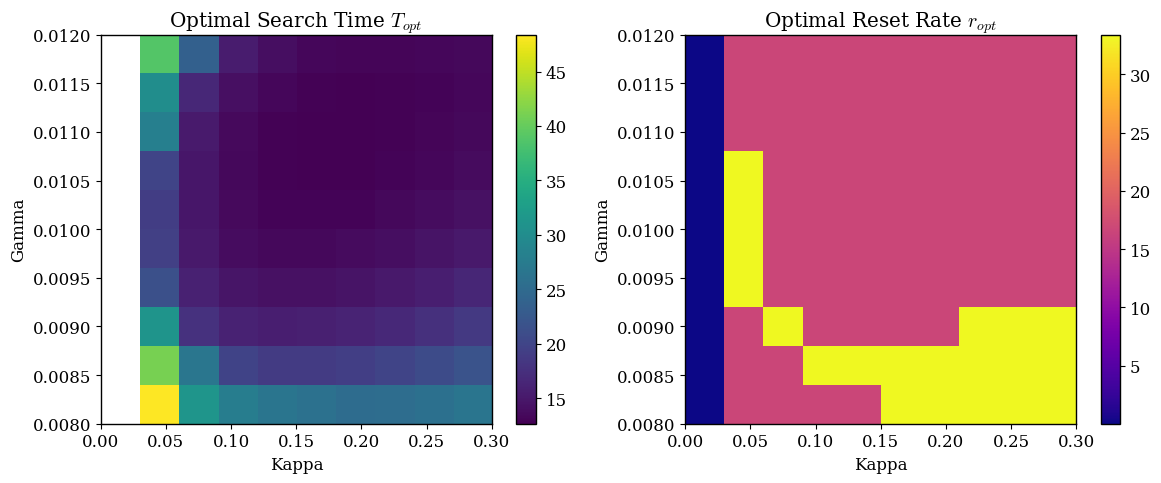

In [41]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Optimal search time heatmap
ax1 = axes[0]
im1 = ax1.imshow(T_optimal, origin='lower', aspect='auto',
                 extent=[kappa_vals[0], kappa_vals[-1], gamma_vals[0], gamma_vals[-1]],
                 cmap='viridis')
ax1.set_xlabel("Kappa")
ax1.set_ylabel("Gamma")
ax1.set_title("Optimal Search Time $T_{opt}$")
fig.colorbar(im1, ax=ax1)

# Optimal reset rate heatmap
ax2 = axes[1]
im2 = ax2.imshow(r_optimal*dt, origin='lower', aspect='auto',
                 extent=[kappa_vals[0], kappa_vals[-1], gamma_vals[0], gamma_vals[-1]],
                 cmap='plasma')
ax2.set_xlabel("Kappa")
ax2.set_ylabel("Gamma")
ax2.set_title("Optimal Reset Rate $r_{opt}$")
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


In [46]:
print(np.unique(r_optimal*dt))
print(r_vals)

[1.000e-02 1.671e+01 3.342e+01]
[    1  1671  3342  5013  6684  8354 10025 11696 13367 15038 16708 18379
 20050 21721 23392 25062 26733 28404 30075 31746 33416 35087 36758 38429
 40100]


In [ ]:
r

0.9777777777777777


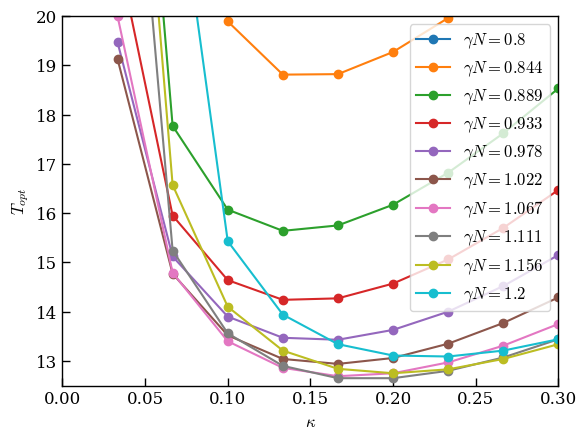

In [40]:
print(gamma_vals[4]*N)
#print(kappa_vals[24])
plot_settings_Framed(None,[[0,0.3],[12.5,20]],[])
for i in range(10):
    plt.plot(kappa_vals,T_optimal[i], marker="o",label=f"$\gamma N={np.round(gamma_vals[i]*N,3)}$")#, ls="")
#plt.plot(kappa_vals,T_optimal[4], marker="o")#, ls="")
#plt.plot(kappa_vals,T_optimal[5], marker="o")#, ls="")
#plt.plot(kappa_vals,T_optimal[6], marker="o")#, ls="")
#plt.plot(kappa_vals,T_optimal[7], marker="o")#, ls="")
#plt.plot(kappa_vals,T_optimal[8], marker="o")#, ls="")
#plt.plot(kappa_vals,T_optimal[9], marker="o",label=f"$\gamma N={gamma_vals[4]*N}$")#, ls="")
#plt.plot(kappa_vals,T_decay_r[9,:,24], marker="o")#, ls="")
plt.ylabel("$T_{opt}$")
plt.xlabel("$\kappa$")
plt.legend()
#plt.yscale("log")
plt.show()

In [28]:
T_optimal
#r_optimal

array([[54.93]])

In [3]:
T_decay_r[4,3]

array([ 14.32, 347.96, 347.96])

In [109]:
r_vals[0]

0.01

In [91]:
checkArr = T_decay_r.copy()

In [ ]:
gg=4
kk=2


checkArr = np.where(checkArr==0, np.inf, checkArr)
#print(checkArr)

#valid_T = checkArr[gg, kk][checkArr[gg, kk] > 0]
valid_T

print(checkArr[gg, kk])
np.argmin(checkArr)

[ 17.25    inf    inf    inf    inf    inf    inf    inf    inf    inf
    inf    inf    inf    inf    inf    inf    inf    inf    inf    inf
    inf 388.98    inf 369.08    inf]


0

In [140]:
for rr, r in enumerate(r_vals):
    print(rr)
    print(r)

0
0.01
1
2.5
2
5.0
3
7.5
4
10.0
5
12.5
6
15.0
7
17.5
8
20.0
9
22.5
10
25.0
11
27.5
12
30.0
13
32.5
14
35.0
15
37.5
16
40.0
17
42.5
18
45.0
19
47.5
20
50.0
21
52.5
22
55.0
23
57.5
24
60.0


In [93]:
T_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
r_optimal = np.zeros((len(gamma_vals), len(kappa_vals)))
T_decay_r = np.where(T_decay_r==0, np.inf, T_decay_r)

for gg in range(len(gamma_vals)):
    for kk in range(len(kappa_vals)):
        valid_T = T_decay_r[gg, kk]
        if len(valid_T) > 0:
            T_optimal[gg, kk] = np.min(valid_T)
            r_optimal[gg, kk] = r_vals[np.argmin(valid_T)]
        else:
            T_optimal[gg, kk] = np.nan  # Mark undefined cases
            r_optimal[gg, kk] = np.nan

In [106]:
np.argmin(T_decay_r[4, 2])

0

1.2
40100


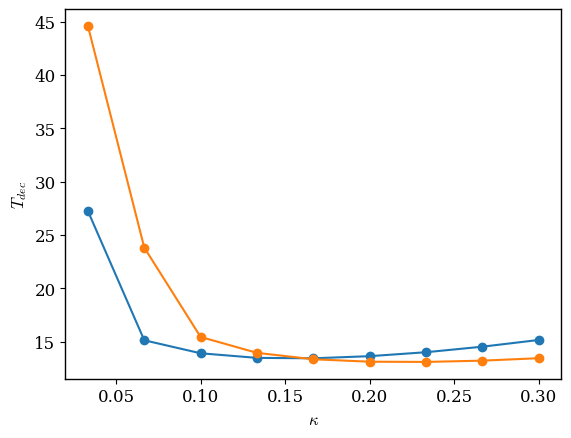

In [20]:
print(gamma_vals[9]*N)
print(r_vals[24])
plt.plot(kappa_vals,T_decay_r[4,:,1], marker="o")#, ls="")
plt.plot(kappa_vals,T_decay_r[9,:,24], marker="o")#, ls="")
plt.ylabel("$T_{dec}$")
plt.xlabel("$\kappa$")
#plt.yscale("log")
plt.show()

In [95]:
T_optimal[4,:]
T_decay_r[4,:,2]
r_optimal[4,:]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [64]:
np.pi/2 * np.sqrt(N)

15.707963267948966

In [20]:
Tcutoff = 400
dt = 0.01
r_vals = np.linspace(1, 6000, 25, dtype=int) * dt
gamma_vals = np.linspace(1/200, 1/50, 10)
kappa_vals = np.linspace(0, 0.3, 10)
N = 100  # System size
w = 1  # Target site

gamma = gamma_vals[4]#1/N
kappa = 0.1

x3 = surv_prob(Tcutoff, dt, 500*dt, N, gamma, w, kappa)

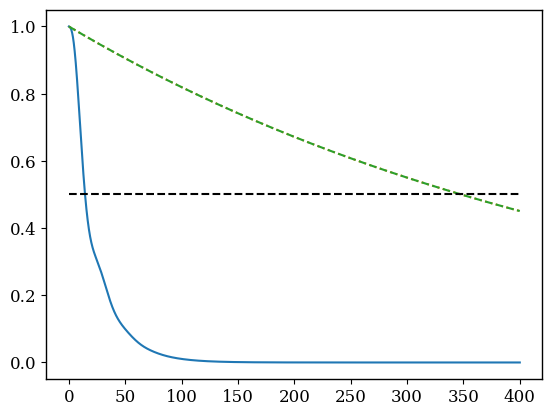

In [21]:
plt.plot(np.linspace(0,Tcutoff,int(Tcutoff/dt)),x)
plt.plot(np.linspace(0,Tcutoff,int(Tcutoff/dt)),x3,ls=":")
plt.plot(np.linspace(0,Tcutoff,int(Tcutoff/dt)),x2,ls="--")
plt.plot([0,400],[0.5,0.5],ls="--",color="k")
plt.show()

In [16]:
x = surv_prob(Tcutoff, dt, 500*dt, N, gamma_vals[0], w, kappa_vals[0])

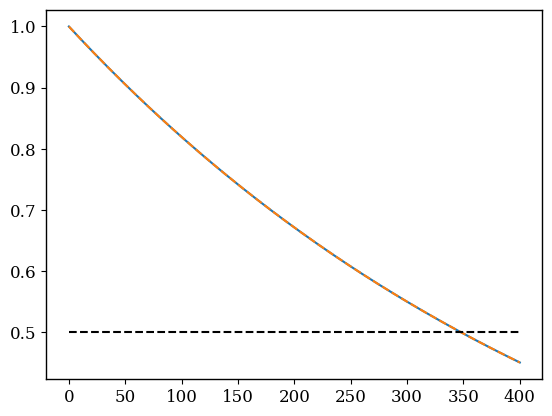

In [17]:
plt.plot(np.linspace(0,Tcutoff,int(Tcutoff/dt)),s_prob)
plt.plot(np.linspace(0,Tcutoff,int(Tcutoff/dt)),x,ls="--")
plt.plot([0,400],[0.5,0.5],ls="--",color="k")
plt.show()

In [139]:
T_decay_r[4, 3, 0]

14.32

In [138]:
find_transition_point2(x, Tcutoff, dt)

346.91

In [120]:
kappa_vals

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ])

In [123]:
print(r_vals/dt)
print(T_decay_r[4,3])

[1.00e+00 2.50e+02 5.00e+02 7.50e+02 1.00e+03 1.25e+03 1.50e+03 1.75e+03
 2.00e+03 2.25e+03 2.50e+03 2.75e+03 3.00e+03 3.25e+03 3.50e+03 3.75e+03
 4.00e+03 4.25e+03 4.50e+03 4.75e+03 5.00e+03 5.25e+03 5.50e+03 5.75e+03
 6.00e+03]
[ 14.32 347.96 347.96 348.72 348.67 346.82 348.72 342.42 348.1  335.75
 346.82 327.13 344.92 316.93 342.42 305.5  339.35 293.2  335.75 280.4
 331.66 267.42 327.13 254.34 322.19]


In [39]:
T_decay_r[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [20]:
def H_CG(args):
    '''Complete graph Hamiltonian'''
    N,gamma,w,kappa = args["N"], args["gamma"], args["w"], args["kappa"]
    ket_s = (1.0/np.sqrt(N))*np.ones((N,1))
    H = -gamma*N*np.dot(ket_s,np.conjugate(ket_s).transpose())
    H = H.astype(complex) # Ensure H can handle complex numbers
    H[w,w] = H[w,w] - 1 - 1j*kappa
    return H   

In [22]:
args = {"N": 100, "gamma": 1/100, "w": 0, "kappa": 0.1}
print(H_CG(args))

[[-1.01-0.1j -0.01+0.j  -0.01+0.j  ... -0.01+0.j  -0.01+0.j  -0.01+0.j ]
 [-0.01+0.j  -0.01+0.j  -0.01+0.j  ... -0.01+0.j  -0.01+0.j  -0.01+0.j ]
 [-0.01+0.j  -0.01+0.j  -0.01+0.j  ... -0.01+0.j  -0.01+0.j  -0.01+0.j ]
 ...
 [-0.01+0.j  -0.01+0.j  -0.01+0.j  ... -0.01+0.j  -0.01+0.j  -0.01+0.j ]
 [-0.01+0.j  -0.01+0.j  -0.01+0.j  ... -0.01+0.j  -0.01+0.j  -0.01+0.j ]
 [-0.01+0.j  -0.01+0.j  -0.01+0.j  ... -0.01+0.j  -0.01+0.j  -0.01+0.j ]]


In [ ]:
def H_CG(args):
    '''Complete graph Hamiltonian'''
    N,gamma,w,kappa = args["N"], args["gamma"], args["w"], args["kappa"]
    ket_s = (1.0/np.sqrt(N))*np.ones((N,1))
    H = -gamma*N*np.dot(ket_s,np.conjugate(ket_s).transpose())
    H = H.astype(complex) # Ensure H can handle complex numbers
    H[w,w] = H[w,w] - 1 - 1j*kappa
    return H   

def surv_prob(Tcutoff, dt, r, args):
    m = int(Tcutoff/dt) # number of time step in the simulation
    N,gamma,w,kappa = args["N"], args["gamma"], args["w"], args["kappa"]
    H =  H_CG(args) # Hamiltonian
    psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))  # initial state (uniform superposition)
    psi_r = (1.0/np.sqrt(N))*np.ones((N,1))  # reset state (uniform superposition)

    s_prob = np.zeros(m)
    s_prob[0] = 1 #Initial value of survival probability
    
    ut = np.asarray(ls.expm(-(1.0j)*H*dt)) #Time Evolution operator

    for j in range(1,m): 
        psit = ut.dot(psi_0) # wavefunction after time evolution of dt
        s_prob[j] = np.abs(np.vdot(psit,psit)) # survival probability

        if r == 0: #No reset condition
            psi_0 = psit
        else:
            if j%r != 0:  #normal condition    
                psi_0 = psit  
            else: # reset conditions
                psi_0 = np.sqrt(s_prob[j])*psi_r

    return s_prob

In [4]:
def find_transition_point(arr):
    left, right = 0, len(arr) - 1
    
    while left < right:
        mid = (left + right) // 2
        if arr[mid] > 0.5:
            left = mid + 1  # Search in the right half
        else:
            right = mid  # Search in the left half
            
    return left if arr[left] <= 0.5 else 0  # Return index or 0 if no transition

In [16]:
s_prob = surv_prob(0.1,1/500,1000)
find_transition_point(s_prob)*0.01

103.62

In [9]:
r = np.linspace(1,6000,50, dtype =int)*0.01
gamma = np.linspace(1/1000,1/100,10)
kappa = np.linspace(0,0.3,10)
T_decay_r = np.zeros((len(gamma),len(kappa),len(r)))

for gg in tqdm(range(len(gamma))):
    for k in range(len(kappa)):
        for i in range(len(r)):
            s_prob = surv_prob(kappa[k],gamma[gg],r[i])
            T_decay_r[gg,k,i]  = find_transition_point(s_prob)*0.01

  0%|          | 0/10 [00:36<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
T_min_opt_s = np.zeros((len(gamma),len(kappa)))
r_opt_s = np.zeros((len(gamma),len(kappa) ))

for gg in range(len(gamma)):
    for i in range(len(kappa)):

        T_min_opt_s[gg,i] = np.min(T_decay_r[gg,i][T_decay_r[gg,i]>0])
        r_opt_s[gg,i] = r[np.argmin(T_decay_r[gg,i][T_decay_r[gg,i]>0])]*0.01